##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# DeepDream

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/generative/deepdream"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で実行</a></td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/generative/deepdream.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a> </td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/generative/deepdream.ipynb">     <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">     GitHubでソースを表示</a></td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/generative/deepdream.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a> </td>
</table>

このチュートリアルには、Alexander Mordvintsev によるこちらの[ブログ記事](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)で説明された DeepDream の最小限の実装が含まれます。

DeepDream はニューラルネットワークが学習したパターンを視覚化する実験です。子供が雲を見てなんらかの形に解釈しようとするのと同様に、DeepDream は過解釈を行って、画像に見いだせるパターンの精度を強化します。

ネットワークを通じて画像を転送し、特定のレイヤーのアクティベーションに関して画像の勾配を計算することで行われています。画像は、これらのアクティベーションを変更しながら、ネットワークに見られるパターンを強化して、夢の中のようなイメージを作り出します。このプロセスは、[InceptionNet](https://arxiv.org/pdf/1409.4842.pdf) と、[映画](https://en.wikipedia.org/wiki/Inception)「インセプション」の因んで、「インセプショニズム」と呼ばれています。

では、ニューラルネットワークに「夢を見させて」、画像に見いだすシュールなパターンを強化する方法を実演することにしましょう。

![Dogception](https://www.tensorflow.org/tutorials/generative/images/dogception.png)

In [2]:
import tensorflow as tf

2022-12-14 22:24:28.894607: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:24:28.894701: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 22:24:28.894710: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [3]:
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

## ドリーム化する画像を選択する

このチュートリアルでは、[ラブラドール](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg)の画像を使用しましょう。

In [4]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

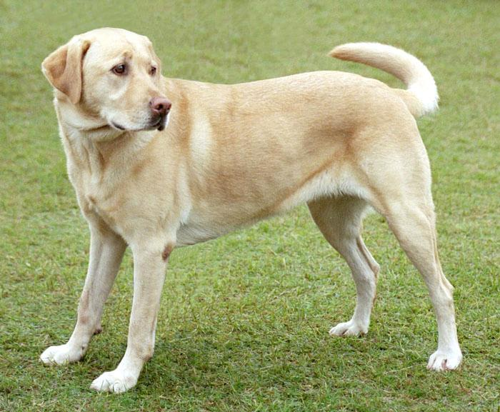

In [5]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

## 特徴抽出モデルを準備する

事前トレーニング済みの画像分類モデルをダウンロードして準備します。もともと DeepDream で使用されたモデルに似た [InceptionV3](https://keras.io/applications/#inceptionv3) を使用します。任意の[事前トレーニング済みのモデル](https://keras.io/applications/#models-for-image-classification-with-weights-trained-on-imagenet)を使用することができますが、レイヤー名を変更する場合は、以下のように調整する必要があります。

In [6]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

    8192/87910968 [..............................] - ETA: 0s

 6987776/87910968 [=>............................] - ETA: 0s

17629184/87910968 [=====>........................] - ETA: 0s

26755072/87910968 [========>.....................] - ETA: 0s

33562624/87910968 [==========>...................] - ETA: 0s

41951232/87910968 [=============>................] - ETA: 0s

50339840/87910968 [================>.............] - ETA: 0s

60497920/87910968 [===================>..........] - ETA: 0s

67829760/87910968 [======================>.......] - ETA: 0s

69484544/87910968 [======================>.......] - ETA: 0s

75505664/87910968 [========================>.....] - ETA: 0s

86917120/87910968 [============================>.] - ETA: 0s

87910968/87910968 [==============================] - 1s 0us/step


DeepDream の考え方は、レイヤーを選択して、画像がレイヤーを徐々に「刺激する」ように「損失」を最大化することです。追加する特徴量の複雑さは、あなたが選択するレイヤーによって異なり、レイヤーが低ければストロークや単純なパターンを生成し、レイヤーが深くなるほど、画像または画像全体の特徴がより洗練されることになります。

InceptionV3 アーキテクチャは非常に大型です（モデルアーキテクチャのグラフについては、TensorFlow の [research リポジトリ](https://github.com/tensorflow/models/tree/master/research/inception)をご覧ください）。DeepDream では、対象のレイヤーは畳み込みが連結されている場所です。こういったレイヤーは InceptionV3 には 11 個あり、'mixed0' から 'mixed10' の名前が付けられています。異なるレイヤーを使用すると、異なった夢のような画像が生成されます。レイヤーが深くなるほどより高度な特徴（目や顔など）に対応し、浅いほどよりシンプルな特徴（エッジ、形状、テクスチャなど）に対応します。以下で選択するレイヤーを自由に試してみてください。ただし、レイヤーが深くなるほど（インデックスが高いレイヤー）、勾配の計算がより深くなるため、トレーニングに時間がかかることに注意してください。

In [7]:
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

## 損失を計算する

損失は、選択されたレイヤーのアクティベーションの和です。損失はレイヤーごとに正規化されるため、より大きなレイヤーからの貢献は小さなレイヤーを上回らないようになっています。通常、損失は、勾配降下法で最小化する量ですが、DeepDream では、勾配上昇法によってこの損失を最大化します。

In [8]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

## 勾配上昇法

選択したレイヤーの損失を計算したら、後は画像に関して勾配を計算し、それを元の画像に追加するだけです。

画像に勾配を追加すると、ネットワークが見るパターンの精度が上がります。各ステップで、ネットワークの特定のレイヤーのアクティベーションを徐々に刺激する画像を作成することになります。

これを行うメソッドは、パフォーマンスを得られるように `tf.function` でラッピングされます。`input_signature` を使用するため、さまざまな画像サイズまたは `steps`/`step_size` 値で関数が再トレースされないようになっています。詳細は、[具象関数ガイド](../../guide/concrete_function.ipynb)をご覧ください。

In [9]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [10]:
deepdream = DeepDream(dream_model)

## メインのループ

In [11]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))
    
    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

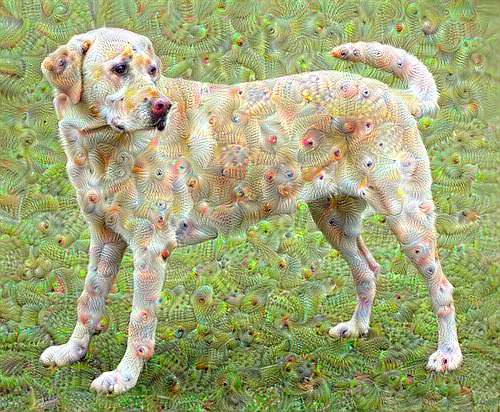

In [12]:
dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=100, step_size=0.01)

## オクターブを実行する

ここまでで非常に素晴らしいものではありますが、この最初の試行にはいくつかの問題があります。

1. 出力にノイズがある（`tf.image.total_variation` 損失で解消可能）。
2. 画像解像度が低い。
3. パターンが同じ粒度で発生しているように見える。

上記のすべての問題を解決するには、1 つのアプローチとして、異なるスケールで勾配上昇法を適用することが挙げられます。こうすれば、より小さなスケールで生成されたパターンをより高いスケールのパターンに統合して、追加の詳細で満たすことができます。

これを行うには、上述の勾配上昇法を実行してから、画像のサイズを増加し（これをオクターブと呼びます）、このプロセスを複数のオクターブで繰り返します。


In [13]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start

8.000179529190063

## オプション: タイルでスケールアップする

画像サイズが大きくなるにつれ、勾配計算の実行に必要な時間とメモリ量も高まるということに注意する必要があります。上記のオクターブ実装は、非常に大きな画像や多数のオクターブでは機能しません。

この問題を回避するには、画像をタイルに分割して、各タイルに対して勾配を計算することができます。

それぞれのタイル計算を行う前に画像にランダムシフトを適用すると、タイルの継ぎ目が現れなくなります。

ランダムシフトの実装から始めましょう。

In [14]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

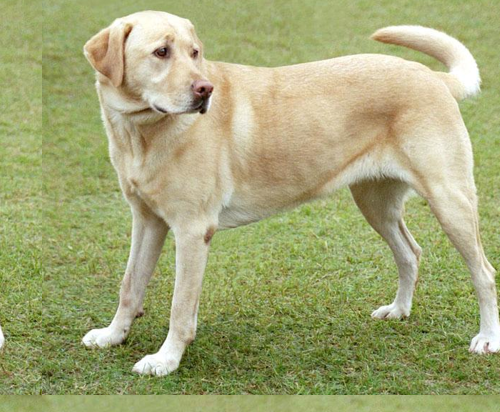

In [15]:
shift, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

以下は、前に定義した `deepdream` 関数のタイルバージョンです。

In [16]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[2], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, img_size, tile_size=512):
    shift, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)
    
    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_size[1], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_size[0], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[y:y+tile_size, x:x+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients 

In [17]:
get_tiled_gradients = TiledGradients(dream_model)

これを合わせると、スケーラブルなオクターブ対応の DeepDream 実装が得られます。

In [18]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01, 
                                octaves=range(-2,3), octave_scale=1.3):
  base_shape = tf.shape(img)
  img = tf.keras.utils.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    new_size = tf.cast(new_size, tf.int32)
    img = tf.image.resize(img, new_size)

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img, new_size)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))
    
  result = deprocess(img)
  return result

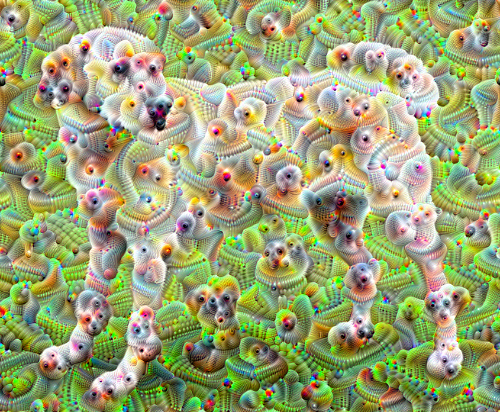

In [19]:
img = run_deep_dream_with_octaves(img=original_img, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

断然に良くなりました！オクターブ、オクターブスケール、アクティベーションされたレイヤーをいろいろ試して、DeepDream 化された画像の変化を確認してみてください。

このチュートリアルで紹介した考え方をさらに拡大した、ニューラルネットワークの視覚化と解釈を行う [TensorFlow Lucid](https://github.com/tensorflow/lucid) というものもありますので、ぜひお試しください。